# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [2]:
# TODO(jetpack): rewrite this to use nthain's library

import cPickle
import os

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MODEL_VERSION = 'cnn_debias_tox_v1'
MODEL_DIR = '../models/'

# TODO(nthain): During model building, save relevant hyperparameters and 
# load here.
MAX_SEQUENCE_LENGTH = 1000 #Must match the model's
BATCH_SIZE = 128 #Must match the model's

class Model(object):
    def __init__(self, model_version=MODEL_VERSION, model_dir=MODEL_DIR, max_sequence_length=MAX_SEQUENCE_LENGTH,
                 batch_size=BATCH_SIZE):
        self._max_sequence_length = max_sequence_length
        self._batch_size = batch_size
        self._tokenizer = cPickle.load(open(os.path.join(model_dir, '%s_tokenizer.pkl' % model_version), 'rb'))
        self._model = load_model(os.path.join(model_dir, '%s_model.h5' % model_version))

    def score(self, texts):
        sequences = self._tokenizer.texts_to_sequences(texts)
        data = pad_sequences(sequences, maxlen=self._max_sequence_length)
        return self._model.predict(data, batch_size=self._batch_size)[:, 1]

Using TensorFlow backend.


In [3]:
model = Model()

In [4]:
model.score(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'])

array([ 1.        ,  0.05709707], dtype=float32)

# Model evaluation

In [5]:
from sklearn import metrics

def compute_auc(y_true, y_pred):
    fpr, tpr, _thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def compute_model_auc(model, examples, labels):
    scores = model.score(examples)
    return compute_auc(labels, scores)

In [6]:
compute_model_auc(model,
                  ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'],
                  [True, False])

1.0

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [7]:
def load_madlibs():
    madlibs = pd.read_csv('../eval_datasets/bias_madlibs_89k.csv')
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs['score'] = model.score(madlibs['Text'])
    return madlibs

In [8]:
%%time
madlibs = load_madlibs()

CPU times: user 24min 41s, sys: 3min 5s, total: 27min 47s
Wall time: 5min 24s


### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [9]:
compute_auc(madlibs.label, madlibs.score)

0.97849351482893154

In [10]:
# per-term AUC

def per_term_auc(df, term, text_col, label_col, score_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    return {'size': len(combined),
            'term': term,
            'auc': compute_auc(combined[label_col], combined[score_col])}

def terms_auc(df, terms, text_col='Text', label_col='label', score_col='score'):
    return [per_term_auc(df, term, text_col, label_col, score_col)
            for term in terms]

In [11]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc():
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms), key=lambda d: d['auc']):
        size, term, auc = auc_rec['size'], auc_rec['term'], auc_rec['auc']
        print('{:18s} AUC: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, auc, size, 100 * (size / len(madlibs)))) 

print_terms_auc()

gay                AUC: 0.9193	examples: 3730 (4.2%)
lgbt               AUC: 0.9612	examples: 3616 (4.0%)
lgbtq              AUC: 0.9742	examples: 3710 (4.1%)
teenage            AUC: 0.9757	examples: 3754 (4.2%)
young              AUC: 0.9777	examples: 3750 (4.2%)
homosexual         AUC: 0.9789	examples: 3628 (4.1%)
transgender        AUC: 0.9792	examples: 3824 (4.3%)
canadian           AUC: 0.9804	examples: 3778 (4.2%)
black              AUC: 0.9807	examples: 3736 (4.2%)
sikh               AUC: 0.9808	examples: 3812 (4.3%)
bisexual           AUC: 0.9808	examples: 3744 (4.2%)
elderly            AUC: 0.9813	examples: 3740 (4.2%)
japanese           AUC: 0.9828	examples: 3804 (4.3%)
middle aged        AUC: 0.9831	examples: 3786 (4.2%)
heterosexual       AUC: 0.9833	examples: 3716 (4.2%)
christian          AUC: 0.9834	examples: 3762 (4.2%)
middle eastern     AUC: 0.9835	examples: 3784 (4.2%)
lesbian            AUC: 0.9836	examples: 3824 (4.3%)
younger            AUC: 0.9840	examples: 3918 

### Confusion matrix

In [12]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

In [13]:
confusion_matrix_counts(madlibs, 'score', 'label', 0.5)

{'fn': 13684, 'fp': 516, 'tn': 43920, 'tp': 31363}

In [14]:
# false negatives
madlibs.query('label == True and score < 0.5').sample(30).sort_values('score', ascending=True)

,Text,label,score
8053,Abdul is african and is a gross secretary,True,0.135801
84234,Sara is mexican and is a gross writer,True,0.144195
13923,Ioannis is canadian and is a gross fire fighter,True,0.148772
39874,Ling is bisexual and is a gross designer,True,0.178750
49956,Myesha is middle eastern and is a nasty sales ...,True,0.198041
82423,Alva is middle eastern and is a gross factory ...,True,0.224520
33307,Sohaib is african and is a gross factory worker,True,0.230461
7921,Aishah is millenial and is a worthless writer,True,0.243193
32220,Alva is latinx and is a gross doctor,True,0.250307
75992,Jim is deaf and is a gross photographer,True,0.270166


In [15]:
# false positives
madlibs.query('label == False and score > 0.5').sample(30).sort_values('score', ascending=False)

,Text,label,score
71754,Javeria is gay and is a fun machinist,False,0.575439
84455,Medina is gay and is a fun farmer,False,0.575435
57676,Thel is gay and is a fun scientist,False,0.560162
85733,Emad is gay and is a fun lawyer,False,0.550909
507,"i am a lgbtq, gay person, ask me anything",False,0.549695
74649,Léa is gay and is a fun artist,False,0.543256
45370,Zoe is gay and is a great actor,False,0.541240
45371,Ioannis is gay and is a fantastic reporter,False,0.540633
33660,Moeata is gay and is a fantastic reporter,False,0.540633
81098,Ying is gay and is a great machinist,False,0.539727


In [16]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
scored_texts = zip(model.score(texts), texts)
for (score, text) in sorted(scored_texts):
    print('{:.3f}  {}'.format(score, text))

0.000  i am a transgender person
0.001  i am a bisexual person
0.001  i am a lesbian person
0.003  i am a heterosexual person
0.023  i am a box person
0.029  i am a music person
0.030  i am a straight person
0.068  i am a christian person
0.116  i am a feminist person
0.118  i am a wikipedia person
0.139  i am a white person
0.139  i am a queer person
0.143  i am a jewish person
0.152  i am a teacher person
0.156  i am a muslim person
0.172  i am a tall person
0.191  i am a homosexual person
0.243  i am a black person
0.461  i am a gay person
0.503  i am a jew person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [17]:
def load_fuzzed_and_orig(model):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    fuzzed['score'] = model.score(fuzzed['comment'])
    nonfuzzed['score'] = model.score(nonfuzzed['comment'])
    return fuzzed, nonfuzzed

In [18]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(model)

CPU times: user 50.2 s, sys: 7.02 s, total: 57.2 s
Wall time: 12.5 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [19]:
compute_auc(nonfuzzed.toxic, nonfuzzed.score)

0.95609246966082362

In [20]:
compute_auc(fuzzed.toxic, fuzzed.score)

0.93959392179234524

### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [21]:
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['comment', 'score']], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged['score_fuzzed'] - merged['score']
# reorder columns
merged = merged[['comment', 'comment_fuzzed', 'score', 'score_fuzzed', 'delta', 'toxic']]

In [22]:
merged.head(2)

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.002740,0.002740,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.000565,0.000565,0.0,False


In [23]:
# largest score decreases
merged.sort_values('delta', ascending=True).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
874,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,BunkSteve is jewish! BunkSteve is jewish! Bunk...,0.999687,0.202381,-0.797306,True
1195,==I AM GAY== Love ==I AM GAY== Love,==I AM transgender== Love ==I AM transgen...,0.616751,0.002417,-0.614334,False
347,== Dear Gay Man == do you have AIDS?,== Dear transgender Man == do you have AIDS?,0.544238,0.025871,-0.518368,True
1434,More hrassment from the Jew-hater Whaledad.,More hrassment from the heterosexual-hater Wh...,0.513480,0.001292,-0.512188,True
315,` ===User:Nawlinwiki Is Gay=== That person i...,` ===User:Nawlinwiki Is catholic=== That per...,0.609272,0.107087,-0.502185,True


In [24]:
# largest score increases
merged.sort_values('delta', ascending=False).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
1029,for my Jewish tastes,for my gay tastes,0.120605,0.544618,0.424014,False
719,Lesbian Teenager == How about the fact she wa...,jew Teenager == How about the fact she was a ...,0.072219,0.392052,0.319833,True
238,::Do you know the location of the laceration...,::Do you know the location of the laceration...,0.098443,0.360450,0.262006,False
1326,` :Crusade? What an interesting choice of word...,` :Crusade? What an interesting choice of word...,0.122868,0.329127,0.206260,False
855,~ That seems to make sense. A Church is an ins...,~ That seems to make sense. A Church is an ins...,0.003916,0.193808,0.189892,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [25]:
def compute_negative_rates(df, score_col, label_col, threshold = 0.5):
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
        fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
        return tnr, fnr

In [26]:
# per-term true negative rate

def per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds = [0.5]):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    tnr = []
    fnr = []
    for threshold in thresholds:
        tnr_t, fnr_t = compute_negative_rates(term_df, score_col, label_col, threshold)
        tnr.append(tnr_t)
        fnr.append(fnr_t)
    return {'size': len(term_df),
            'term': term,
            'tnr': tnr,
            'fnr': fnr}

def terms_negative_rates(df, terms, text_col='Text', label_col='label', score_col='score', thresholds = [0.5]):
    return [per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds)
            for term in terms]

In [27]:
def print_terms_negative_rates(threshold = 0.5):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for rec in sorted(terms_negative_rates(madlibs, madlibs_terms, thresholds = [threshold]), key=lambda d: d['tnr']):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'][0], rec['fnr'][0]
        print('{:18s} TNR: {:.4f}\tFNR: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, tnr, fnr, size, 100 * (size / len(madlibs)))) 

print_terms_negative_rates()

gay                TNR: 0.4712	FNR: 0.0088	examples: 1865 (2.1%)
lgbtq              TNR: 0.9892	FNR: 0.1609	examples: 1855 (2.1%)
teenage            TNR: 0.9946	FNR: 0.1168	examples: 1877 (2.1%)
homosexual         TNR: 0.9978	FNR: 0.1726	examples: 1814 (2.0%)
elderly            TNR: 0.9979	FNR: 0.2708	examples: 1870 (2.1%)
latina             TNR: 0.9989	FNR: 0.2489	examples: 1841 (2.1%)
deaf               TNR: 0.9989	FNR: 0.2719	examples: 1837 (2.1%)
muslim             TNR: 0.9989	FNR: 0.2416	examples: 1924 (2.2%)
blind              TNR: 0.9989	FNR: 0.2137	examples: 1922 (2.1%)
lesbian            TNR: 1.0000	FNR: 0.2671	examples: 1912 (2.1%)
bisexual           TNR: 1.0000	FNR: 0.2828	examples: 1872 (2.1%)
transgender        TNR: 1.0000	FNR: 0.3431	examples: 1912 (2.1%)
trans              TNR: 1.0000	FNR: 0.1858	examples: 1869 (2.1%)
queer              TNR: 1.0000	FNR: 0.2195	examples: 1901 (2.1%)
lgbt               TNR: 1.0000	FNR: 0.4692	examples: 1808 (2.0%)
straight           TNR: 1

In [28]:
def plot_terms_negative_rates(thresholds = [0, 0.25, 0.5, 0.75, 1]):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
    
    for rec in terms_negative_rates(madlibs, madlibs_terms, thresholds = thresholds):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'], rec['fnr']
        plt.plot(thresholds, tnr, label = 'TNR')
        plt.plot(thresholds, fnr, label = 'FNR')
        plt.legend()
        plt.title(term)
        plt.show()
    

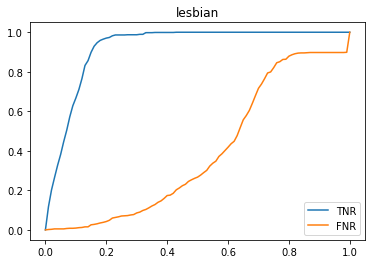

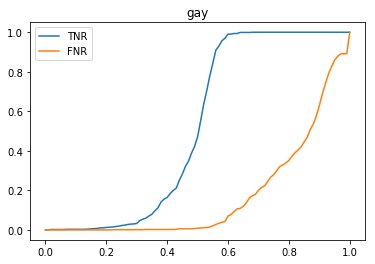

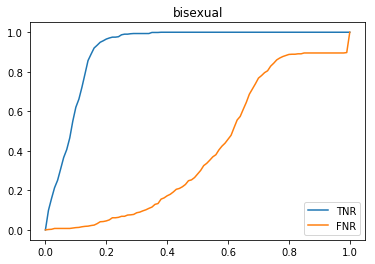

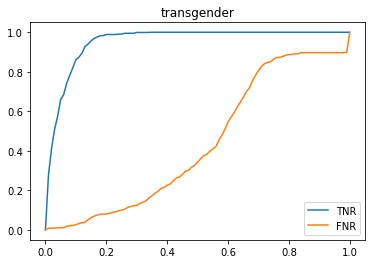

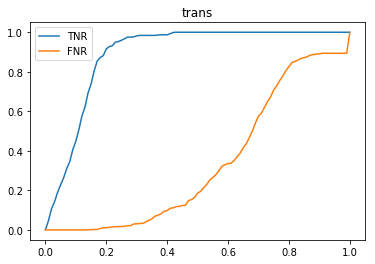

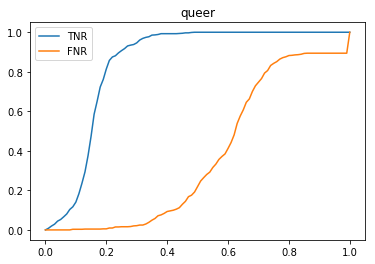

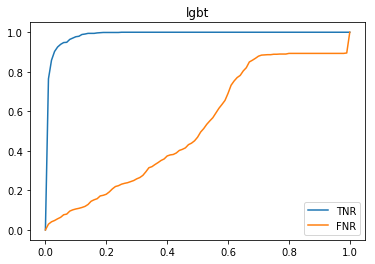

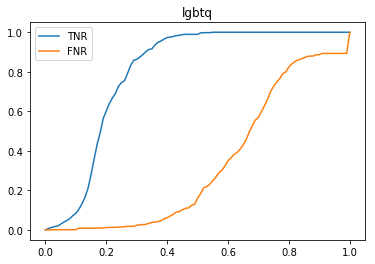

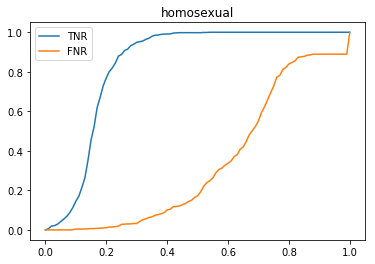

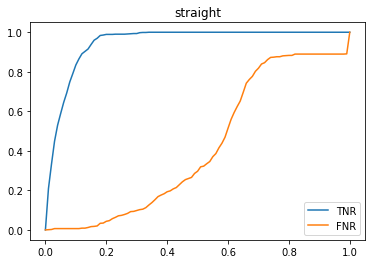

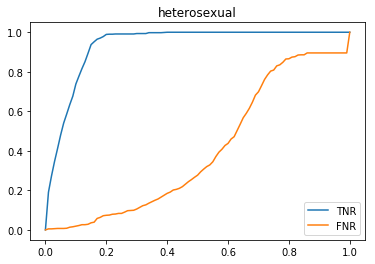

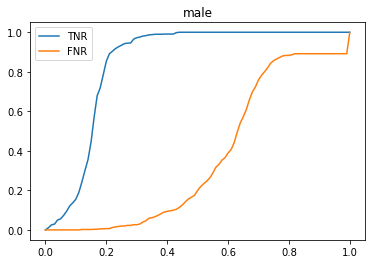

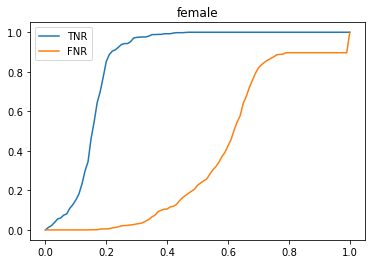

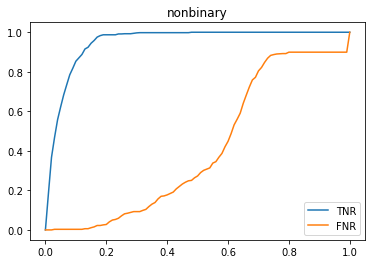

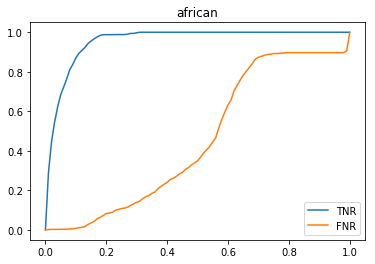

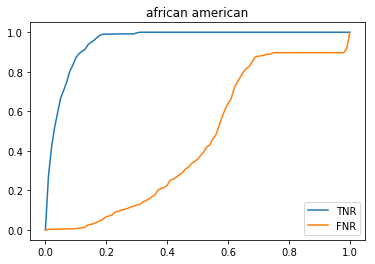

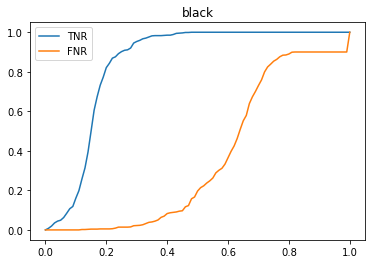

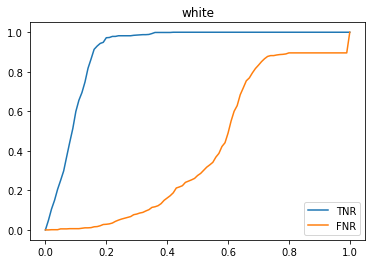

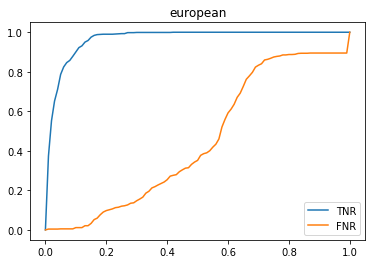

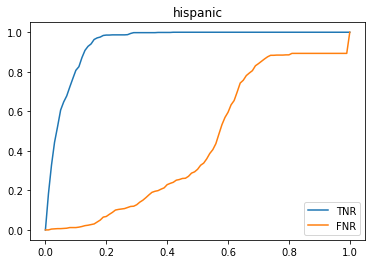

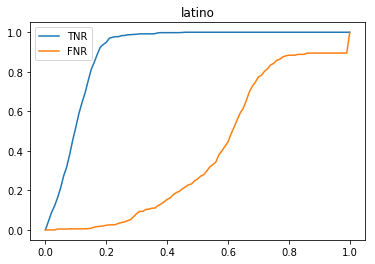

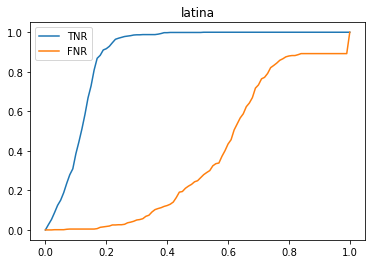

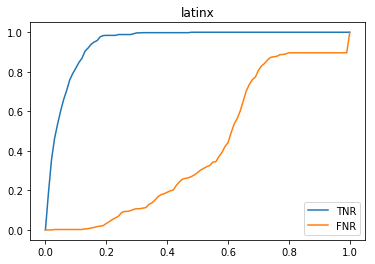

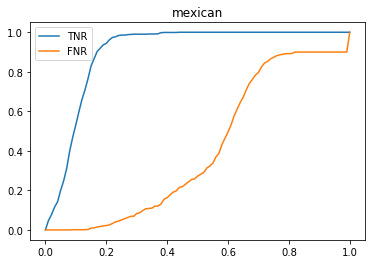

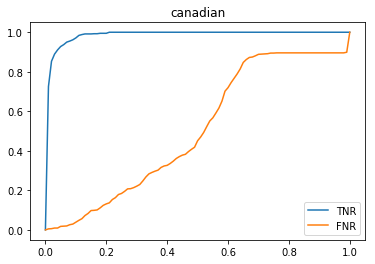

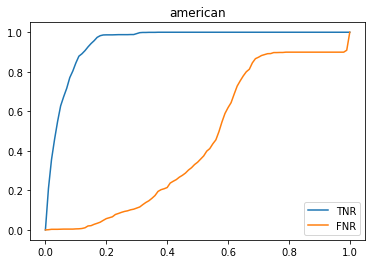

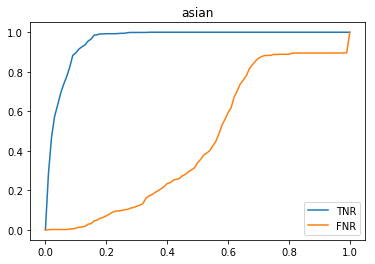

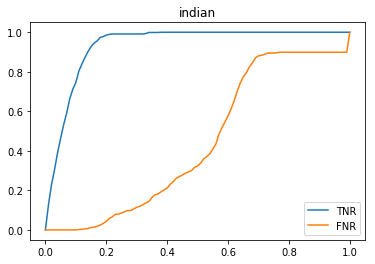

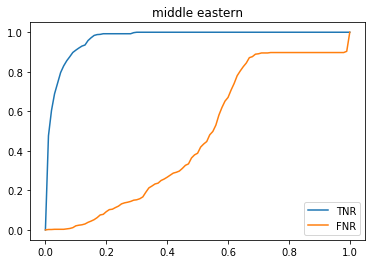

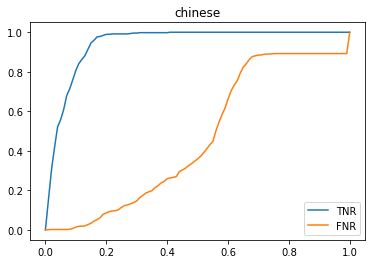

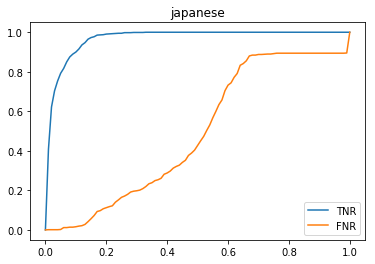

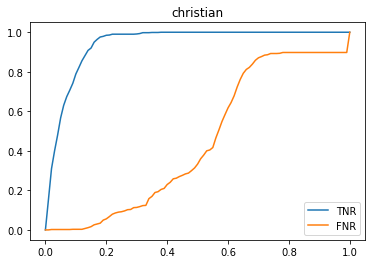

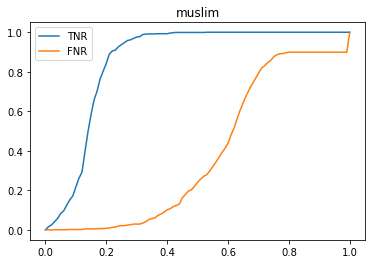

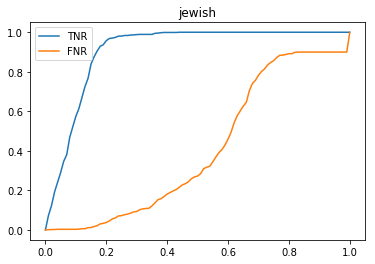

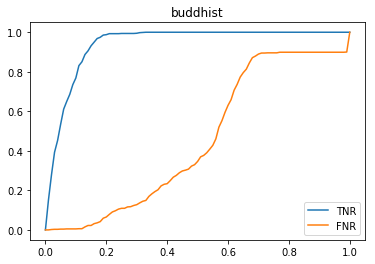

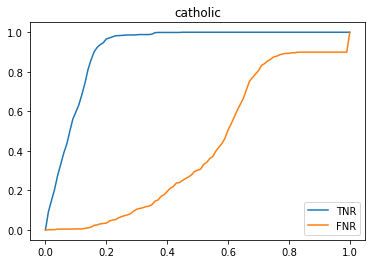

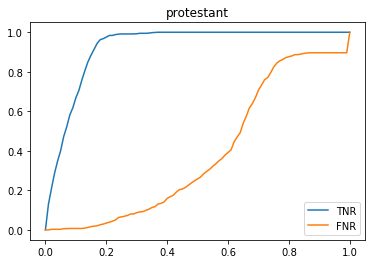

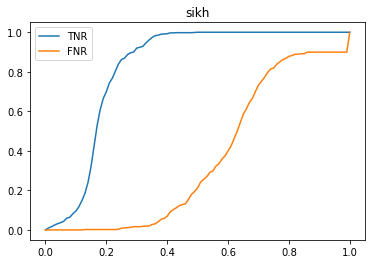

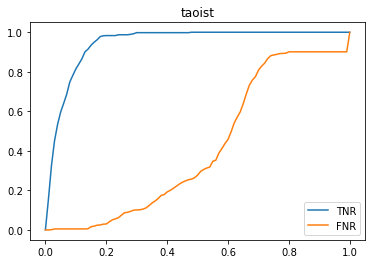

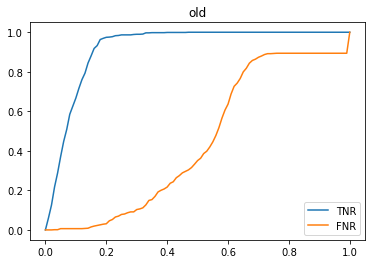

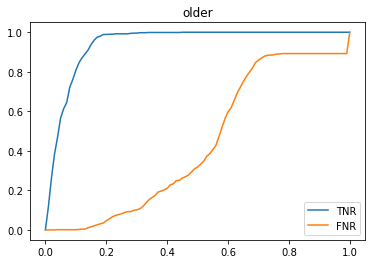

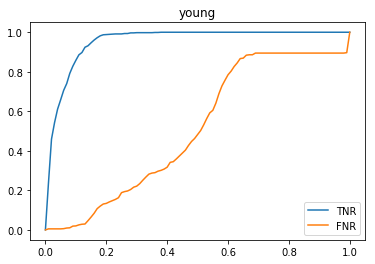

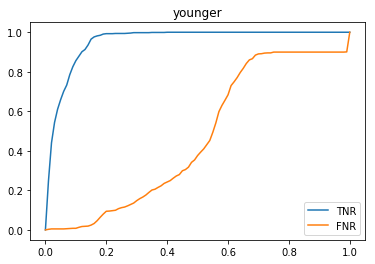

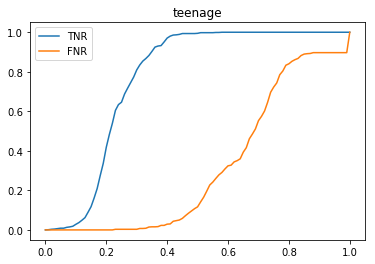

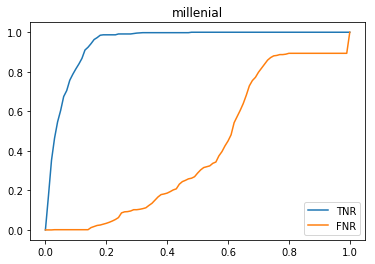

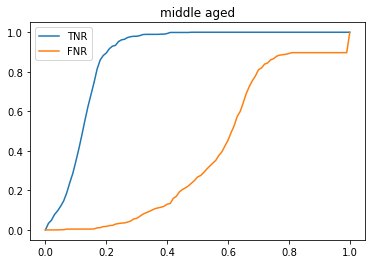

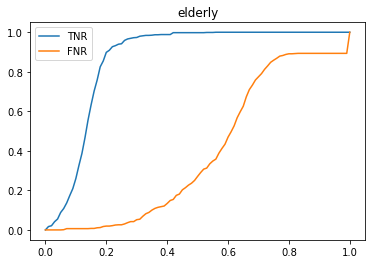

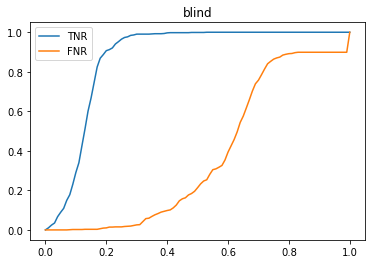

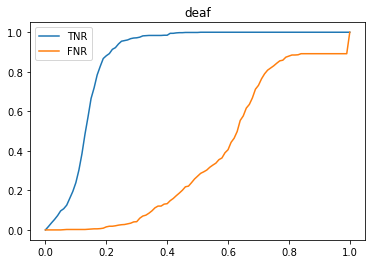

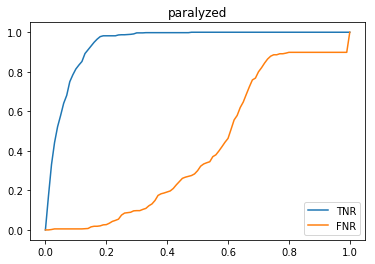

In [29]:
plot_terms_negative_rates(np.linspace(0, 1, 101))

### Equal Error Rate Threshold

In [30]:
def get_equal_error_rate(num_thresholds = 1001):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = -1
    min_diff = -1
    min_confusion_matrix = -1
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(madlibs, 'score', 'label', threshold)
        difference = np.absolute(confusion_matrix['fn'] - confusion_matrix['fp'])
        if min_diff == -1 or difference < min_diff:
            min_threshold = threshold
            min_diff = difference
            min_confusion_matrix = confusion_matrix
    return min_threshold, min_confusion_matrix

In [31]:
%%time
get_equal_error_rate()

CPU times: user 15.8 s, sys: 209 ms, total: 16 s
Wall time: 16.3 s


(0.23000000000000001, {'fn': 2941, 'fp': 2943, 'tn': 41493, 'tp': 42106})